# 6imilarité group 2

### Introduction

Ce notebook vise à entraîner un modèle ResNet18 pour la tâche de classification des voitures en ~200 classes différentes.

Nous commencerons par importer les bibliothèques nécessaires et configurer le GPU pour l'entraînement.

In [1]:
# Importing required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import zipfile
import random
import torchvision
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
from IPython.display import Image as ImageDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

from torchcam.utils import overlay_mask

import time
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Tuple, Dict, Any, List

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA A2


### Téléchargement du jeu de données

Avant de continuer, téléchargeons le jeu de données Stanford Car Dataset depuis Kaggle. Ce jeu de données contient des images de voitures classées en classes par dossiers.

Nous utiliserons l'API Kaggle pour télécharger le jeu de données directement dans notre environnement de notebook.

Assurez-vous d'avoir configuré l'API Kaggle dans votre environnement.

**Si ce n'est pas le cas :**
- Accédez aux paramètres de votre profil
- Créez un nouveau jeton
- Placez le fichier kaggle.json téléchargé à cet emplacement /home/"<user_name>"/.kaggle/

In [2]:
!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)


### Variables utiles et Prétraitement des données

Avant de commencer l'entraînement de notre modèle, nous devons prétraiter le jeu de données. Cela implique de créer les répertoires nécessaires, de décompresser le jeu de données et de diviser les données de test initiales en ensembles d'entraînement et de validation.

Définissons quelques fonctions auxiliaires pour ces étapes de prétraitement.


In [3]:
# Define paths for train, validation, and test data

DATA_PATH = "data/car_data/car_data/"
TRAIN_PATH = "data/car_data/car_data/train"
VAL_PATH = "data/car_data/car_data/val"
TEST_PATH = "data/car_data/car_data/test"

In [4]:
def create_dir(directory_path: str) -> None:
    """
    Create a directory if it doesn't exist.

    Args:
        directory_path (str): Path of the directory to be created.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def unzip_data() -> None:
    """
    Unzip the downloaded dataset.
    """
    with zipfile.ZipFile("stanford-car-dataset-by-classes-folder.zip", "r") as zip_file:
        zip_file.extractall("data/")

def split_initial_test_folder() -> None:
    """
    Split the initial test data into training and validation data.
    """
    for class_folder in os.listdir(TEST_PATH):
        create_dir(os.path.join(VAL_PATH, class_folder))
        
        for i, image_name in enumerate(os.listdir(os.path.join(TEST_PATH, class_folder))):
            if i % 5 == 0: # Move 1/5 of data inside training dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(TRAIN_PATH, class_folder, image_name))
            elif i % 5 < 3: # Move 2/5 of data inside validation dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(VAL_PATH, class_folder, image_name))

### Vérification et Préparation de la Partition des Données

Avant de procéder au prétraitement des données, vérifions si la partition de validation existe déjà. Si ce n'est pas le cas, nous allons créer les répertoires nécessaires, décompresser le jeu de données et diviser les données de test initiales en ensembles d'entraînement et de validation.

In [5]:
if os.path.exists(VAL_PATH):
    print("Repartion already exist")
else:
    create_dir("data")
    unzip_data()
    split_initial_test_folder()

Repartion already exist


### Comptage des échantillons et Vérification de la Structure des Répertoires

Nous allons maintenant compter le nombre d'échantillons dans chaque partition et vérifier la structure des répertoires pour assurer la cohérence.

| Jeu de données     | Nombre d'échantillons | Proportion d'échantillons |
|--------------------|-----------------------|---------------------------|
| Entraînement       | 9826                  | 0.60                      |
| Validation         | 3262                  | 0.20                      |
| Test               | 3093                  | 0.20                      |
| Total              | 16181                 | 1.00                      |


In [6]:
# Count the number of samples in each partition and verify the directory structure
count_train, count_val, count_test = 0, 0, 0

for class_folder in os.listdir(TRAIN_PATH):
    count_train += len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
for class_folder in os.listdir(VAL_PATH):
    count_val += len(os.listdir(os.path.join(VAL_PATH, class_folder)))
for class_folder in os.listdir(TEST_PATH):
    count_test += len(os.listdir(os.path.join(TEST_PATH, class_folder)))

total = count_train + count_val + count_test
print(f"Training samples: {count_train}, Validation samples: {count_val}, Test samples: {count_test}, Total {total}")
print(f"Proportions => Train:{round(count_train / total, 2)}, Validation: {round(count_val / total, 2)}, Test:{round(count_test / total, 2)}")

# Assert the equality of the number of classes in each partition
assert len(os.listdir(TRAIN_PATH)) == len(os.listdir(VAL_PATH)) == len(os.listdir(TEST_PATH))

Training samples: 9826, Validation samples: 3262, Test samples: 3093, Total 16181
Proportions => Train:0.61, Validation: 0.2, Test:0.19


### Visualisation d'Échantillons Aléatoires du Jeu de Données d'Entraînement

Nous allons maintenant visualiser des échantillons aléatoires du jeu de données d'entraînement pour avoir une idée des images dans notre ensemble de données.

In [7]:
# Util function
def truncate_string(string: str, max_length: int) -> str:
    """
    Truncate a string to a specified maximum length.

    Args:
        string (str): The string to truncate.
        max_length (int): The maximum length of the truncated string.

    Returns:
        str: The truncated string.
    """
    if len(string) > max_length:
        return string[:max_length - 3] + " [...]"
    else:
        return string

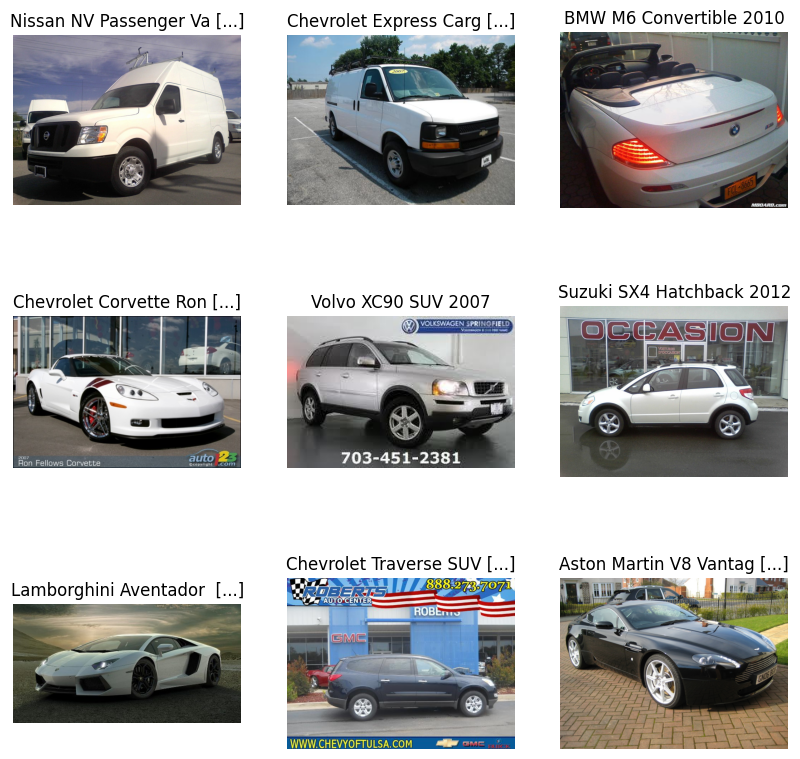

In [8]:
# Visualizing Random Samples from Training Data
plt.figure(figsize=(10, 10))
classes_directory = random.choices(os.listdir(TRAIN_PATH), k=9)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(TRAIN_PATH, class_name)))
    image_path = os.path.join(TRAIN_PATH, class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

### Diagramme en barres du poids de classe à l'intérieur des ensembles de données

Nous allons maintenant compter le nombre de voitures dans chaque classe du jeu de données d'entraînement et visualiser les comptages à l'aide d'un graphique en barres. De plus, nous montrerons le nombre moyen d'échantillons et le tracerons comme une ligne horizontale pour référence.

In [9]:
car_count_dict = {}

for class_folder in os.listdir(TRAIN_PATH):
    count = len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
    car_count_dict[class_folder] = count

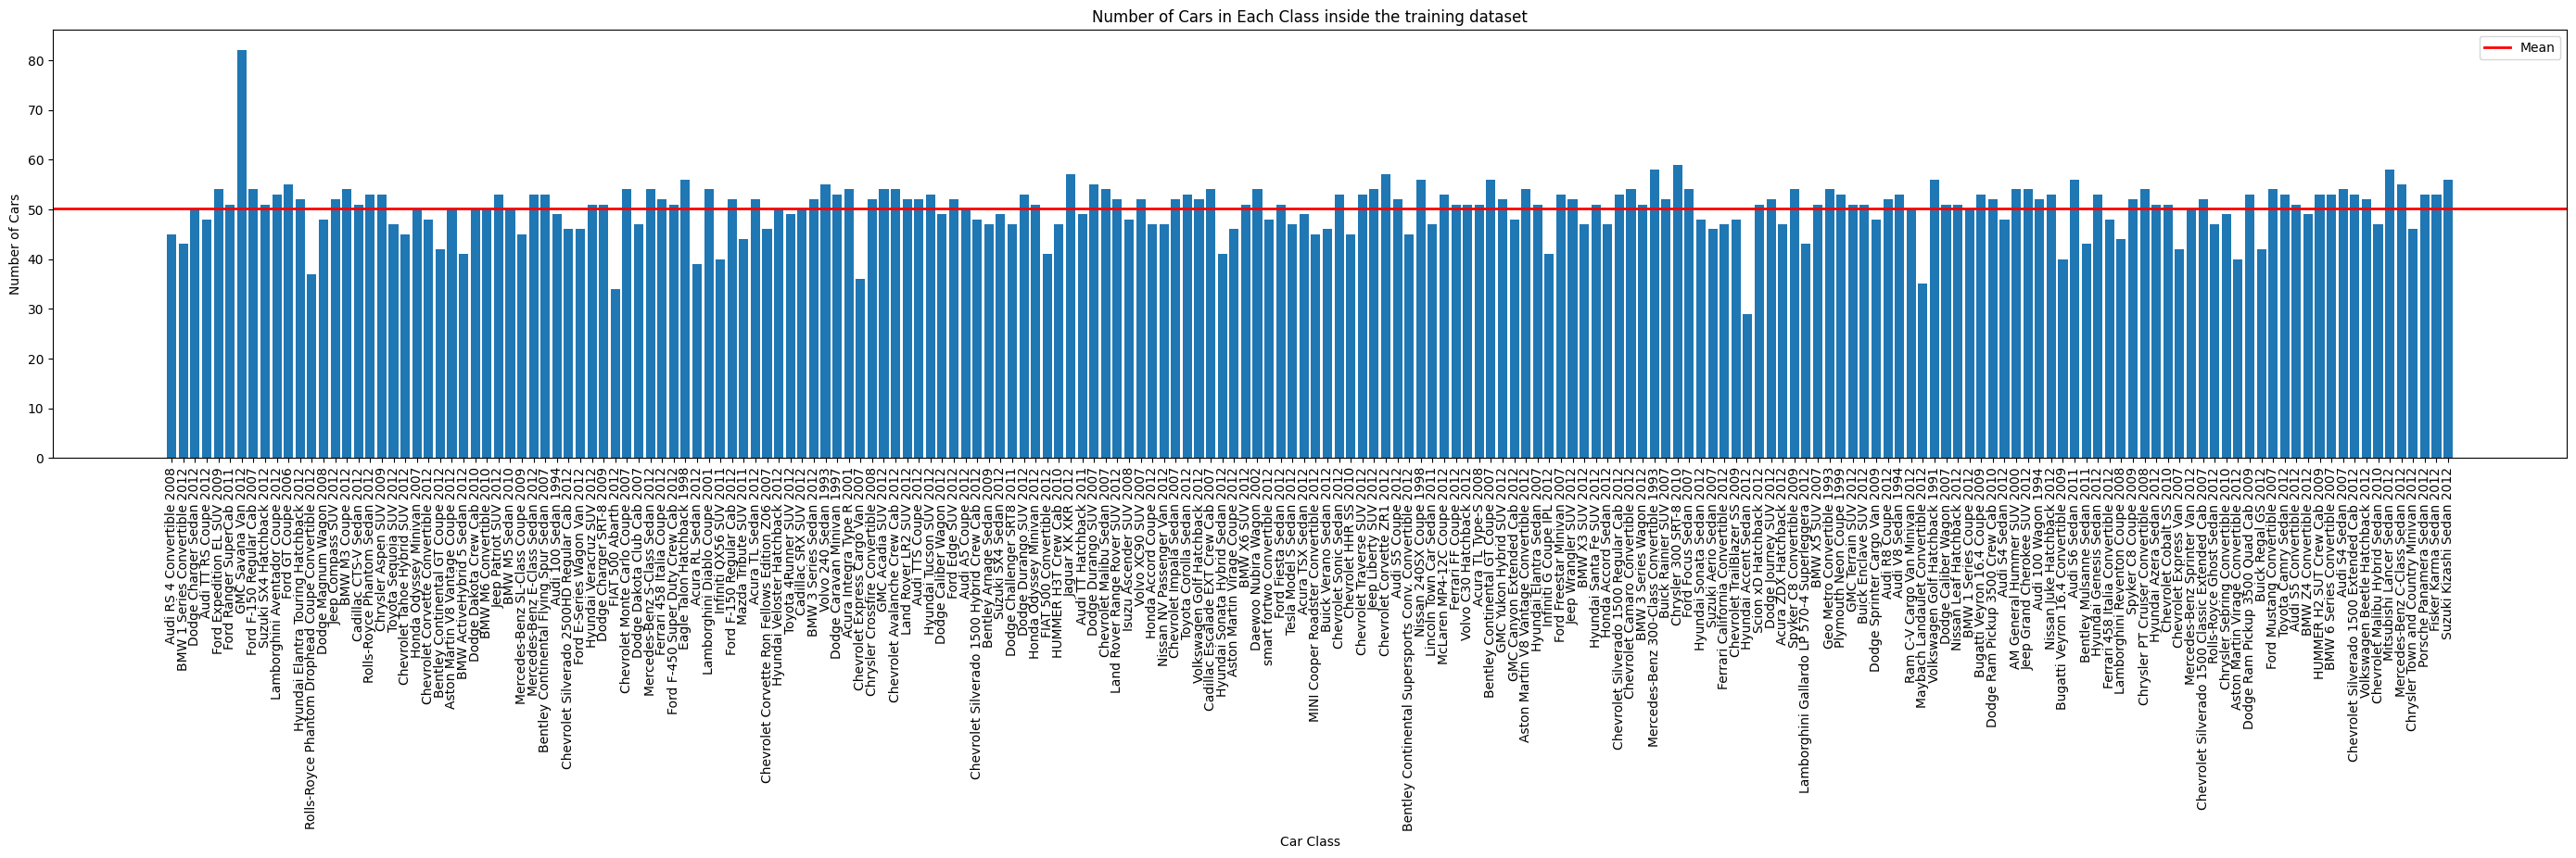

In [10]:
# Visualizing the car counts for each class
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the training dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

**Discussion** : Comme nous pouvons le voir, le jeu de données est un peu déséquilibré. Par conséquent, nous pourrions envisager d'ajouter des poids de classe à la perte de notre futur modèle.

**L'objectif est de pénaliser les classes surreprésentées et de promouvoir les classes sous-représentées.**

### Vérifier la cohérence de l'ensemble de données de test

Jetons un coup d'œil à l'ensemble de données de test maintenant ! Nous allons compter le nombre de voitures dans chaque classe de l'ensemble de données de test et visualiser les comptages à l'aide d'un graphique en barres. Vous êtes-vous déjà demandé combien de voitures de chaque type se trouvent dans l'ensemble de test ? Découvrons-le !

In [11]:
car_count_dict = {}

for class_folder in os.listdir(TEST_PATH):
    count = len(os.listdir(os.path.join(TEST_PATH, class_folder)))
    car_count_dict[class_folder] = count

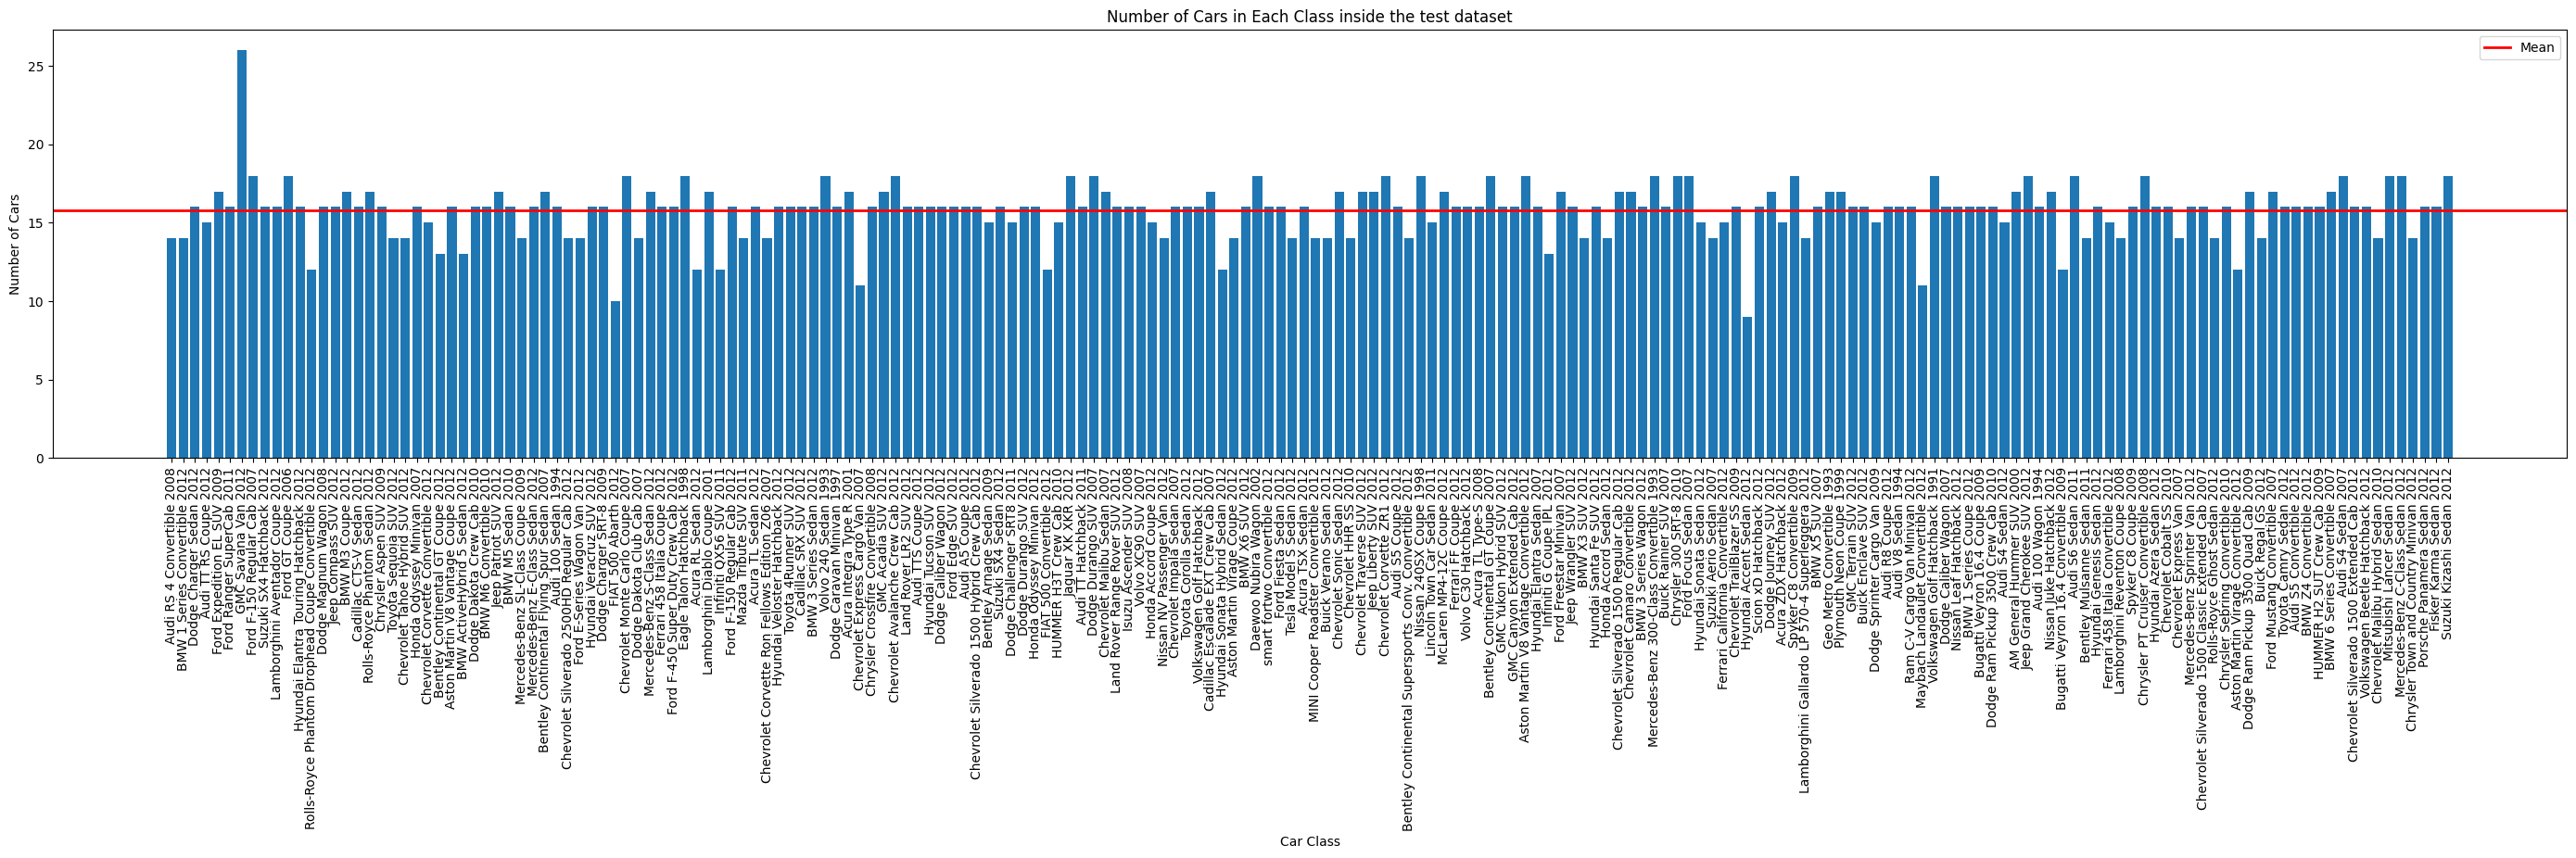

In [12]:
# Visualizing the car counts for each class in the test dataset
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the test dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

**Discussion :** La distribution reflète étroitement celle de l'ensemble de données d'entraînement. Nous avons sélectionné 20 % de l'ensemble de données total pour garantir une moyenne minimale de 16 images par classe.

### Préparation des données pour l'entraînement du modèle

Il est temps de préparer nos données pour l'entraînement du modèle ! Mais avant, voyons combien de cœurs CPU nous avons à notre disposition pour accélérer le processus.

In [13]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"{num_cores = }")

num_cores = 104


In [14]:
# Imported from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

**Augmentation des données**

Maintenant que c'est réglé, plongeons-nous dans la transformation de notre ensemble de données. Nous avons importé quelques astuces de transformation directement depuis ImageNet pour nous assurer que nos données sont en excellent état.

Nous redimensionnerons nos images en 224x224 pixels (afin d'avoir une bonne adaptation pour la couche d'entrée de ResNet18), appliquerons quelques retournements et rotations aléatoires pour garder les images uniques, et saupoudrerons un peu de jitter de couleur pour une bonne mesure.

Enfin, nous convertirons tout en tenseurs et leur donnerons une bonne normalisation en utilisant des valeurs de moyenne et d'écart type empruntées au puissant ImageNet. Nos données seront prêtes et prêtes à être consommées par notre modèle !

In [15]:
# defining the transformation for the dataset
train_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

val_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

### Chargement des données pour l'entraînement du modèle

Il est temps de charger nos données et de les préparer pour l'entraînement ! Nous allons créer quelques chargeurs qui nous aideront à alimenter efficacement nos données dans le modèle. Mais d'abord, mettons en place quelques tailles de lots et un peu de magie de multiprocessing.

In [16]:
BATCH_SIZE = 32

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = num_cores)

val_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = val_train_augmentation)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_train_augmentation)

# Create a dictionary to associate image indices with image path
image_index_to_path = defaultdict(str)
with tqdm(test_dataset) as t_ds:
    for i, (image, _) in tqdm(enumerate(t_ds)):
        image_path = test_dataset.imgs[i][0]
        image_index_to_path[i] = image_path

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

100%|██████████| 3093/3093 [00:37<00:00, 81.42it/s] 
3093it [00:37, 81.42it/s]


### Présentation du modèle ResNet-18 !

Ce modèle vient directement de torchvision, pré-entraîné sur ImageNet.

In [17]:
model = torchvision.models.resnet18(progress=True, pretrained=True)

num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)

# Adapt the last dense layer for the 200 avalaible classes
model.fc = nn.Linear(num_ftrs, no_classes)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Exploration des paramètres du modèle

Jetons un coup d'œil sous le capot et explorons les paramètres de notre modèle ResNet-18. Ces paramètres détiennent la clé du fonctionnement interne du modèle, y compris les poids et les biais de chaque couche.

In [18]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Calcul des poids de classe

Calculons les poids de classe en fonction de la distribution des échantillons dans chaque classe.

In [19]:
# Transform string labels into int labels
counter = 0
label_to_int = {}

for class_name in os.listdir(TRAIN_PATH):
    label_to_int[class_name] = counter
    counter += 1

# Get an histogram of the classes weight
sample_to_int = []
for class_folder in os.listdir(TRAIN_PATH):
    for _ in os.listdir(os.path.join(TRAIN_PATH, class_folder)):
        sample_to_int.append(label_to_int[class_folder])

y = np.array(sample_to_int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

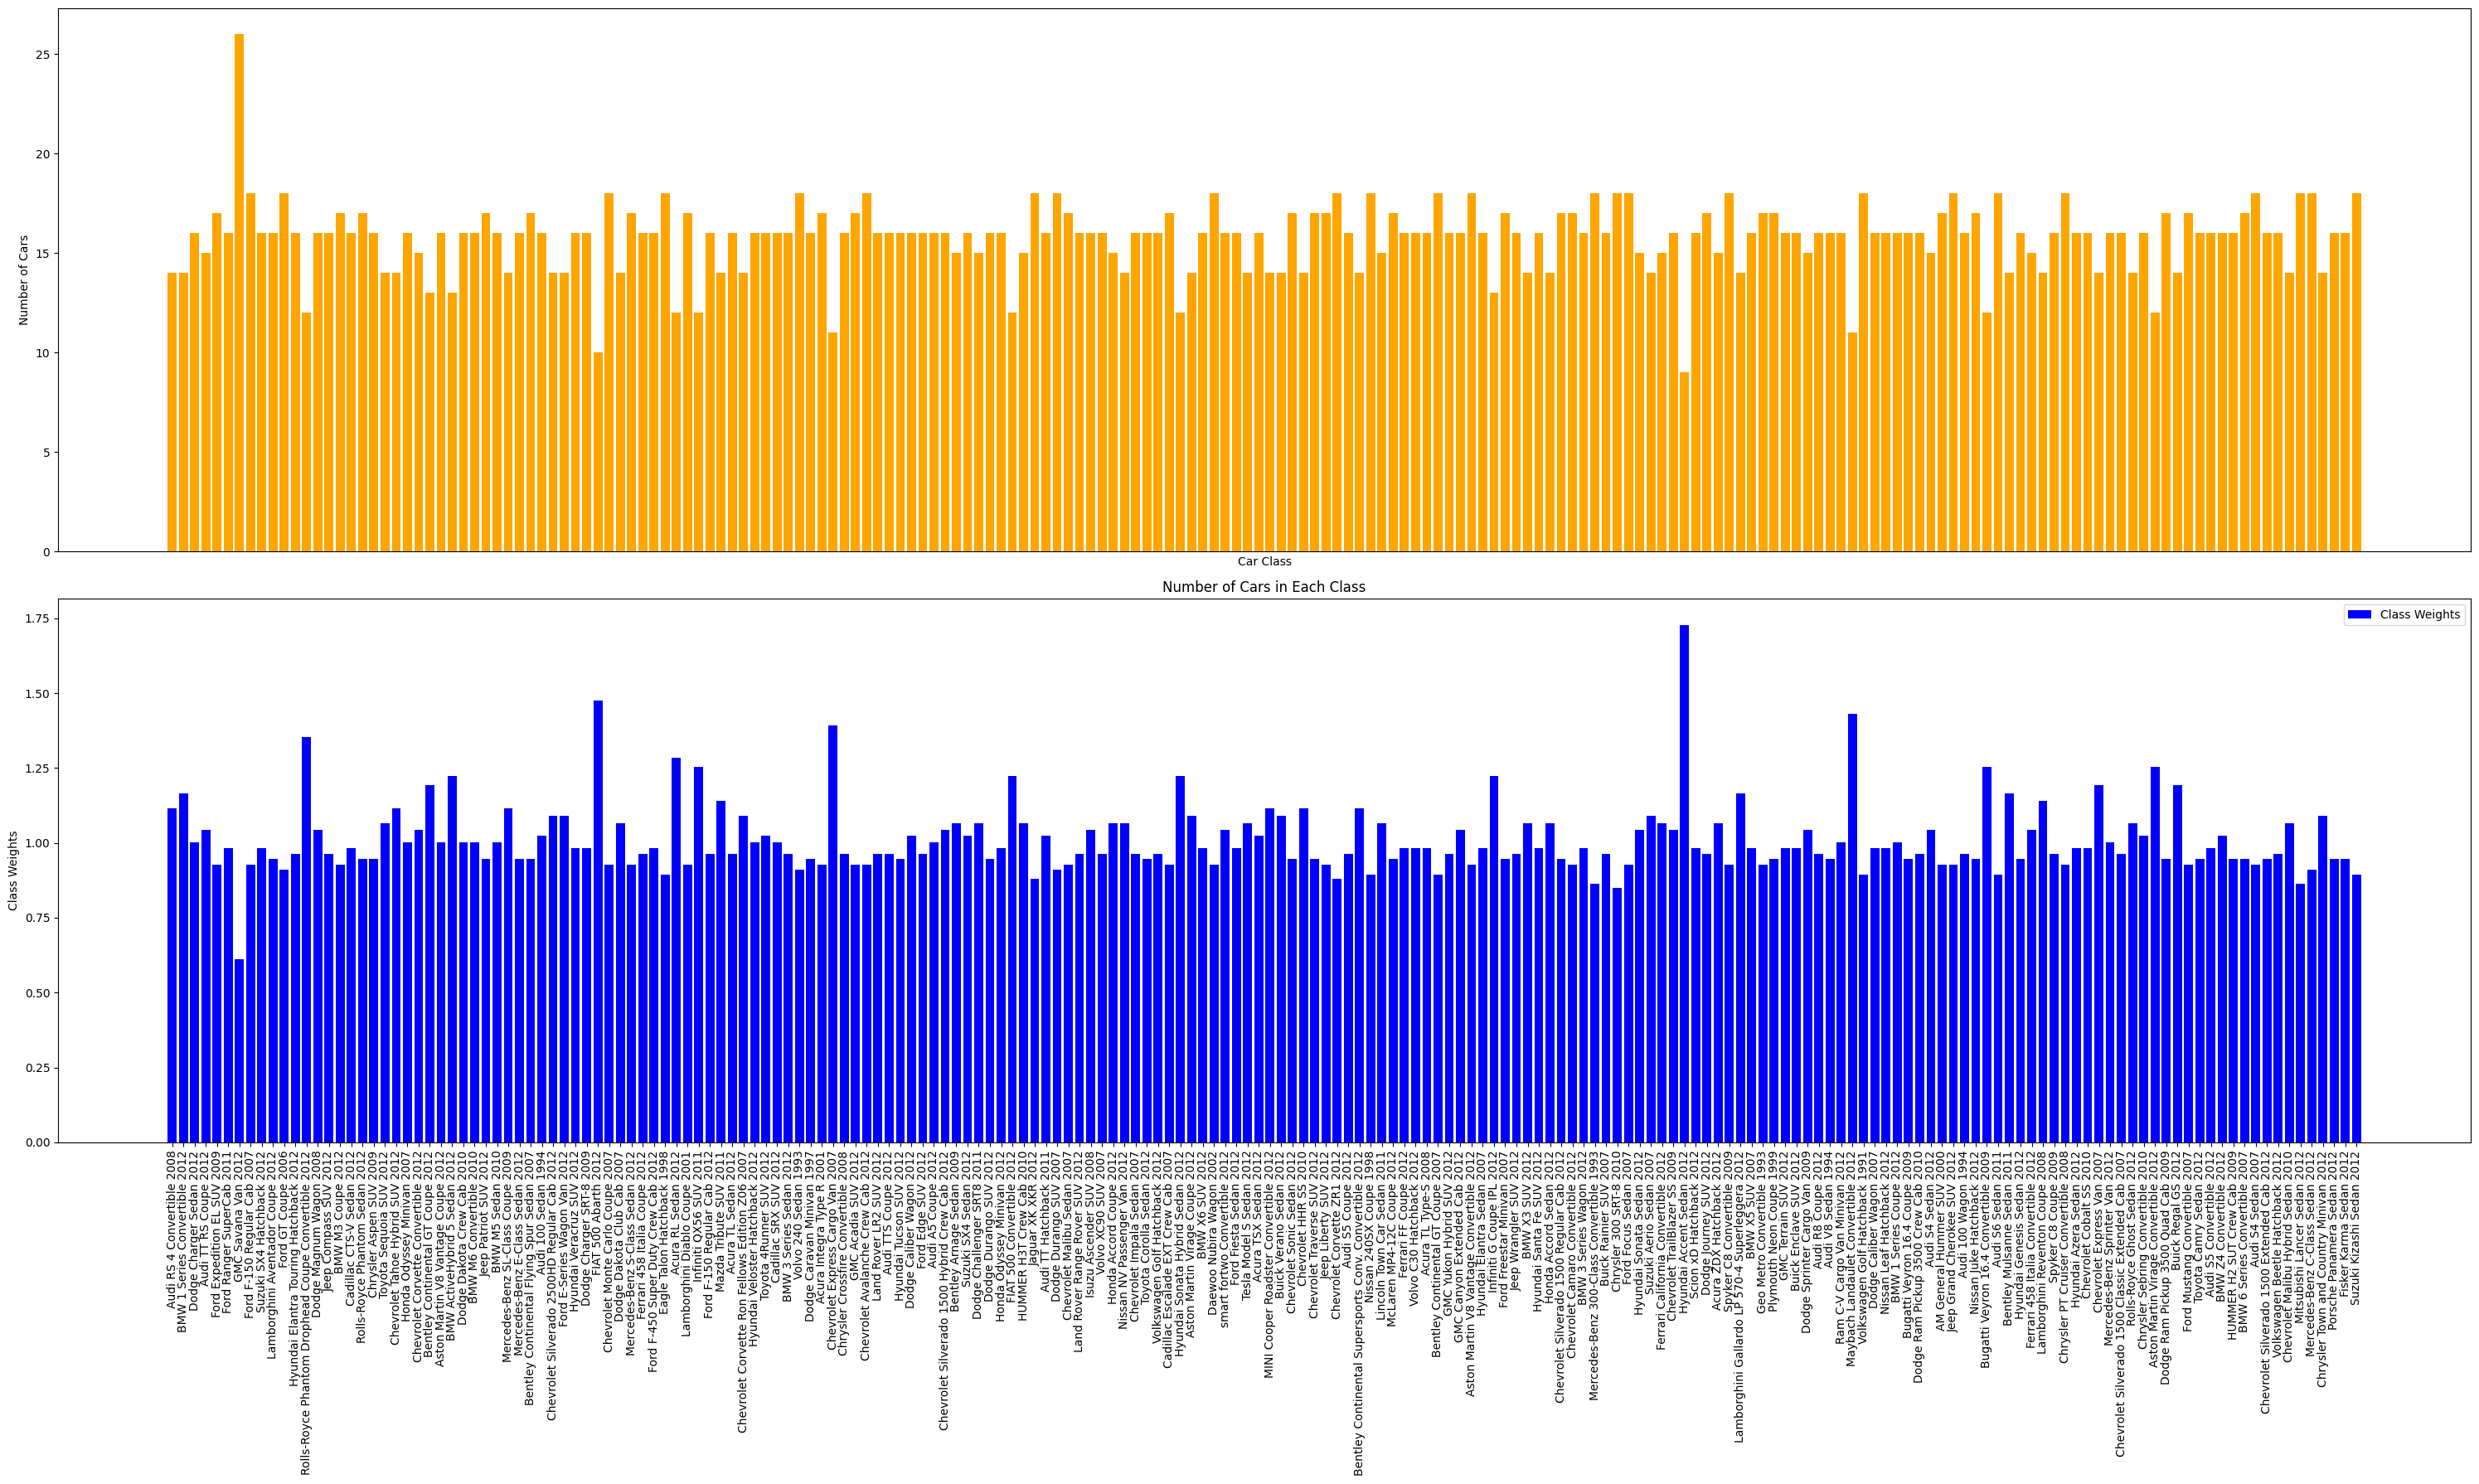

In [20]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 18))

# Plot the first bar graph on the first subplot (top)
ax1.bar(car_count_dict.keys(), car_count_dict.values(), color='orange', label='Car Count')
ax1.set_xlabel('Car Class')
ax1.set_ylabel('Number of Cars')
ax1.set_xticks([])

# Plot the second bar graph on the second subplot (bottom)
ax2.bar(car_count_dict.keys(), class_weights, color='blue', label='Class Weights')
ax2.set_ylabel('Class Weights')
ax2.set_title('Number of Cars in Each Class')
ax2.legend()

# Rotate x-axis labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Discussion :** Voici la pénalité dont nous avons discuté il y a quelques cellules. Ici, nous pouvons voir la distribution des poids correspondant à la distribution des échantillons à l'intérieur des classes disponibles.

### Définition des hyperparamètres et préparation du modèle pour l'entraînement

Préparons notre modèle pour l'entraînement ! Tout d'abord, nous allons déplacer notre modèle vers le périphérique spécifié (CPU ou GPU). Ensuite, nous définirons notre fonction de perte et notre optimiseur pour optimiser les performances de notre modèle.

In [21]:
model = model.to(device)

# Defining the loss function and the optimizer
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
optimizer = optim.Adam(model.parameters(), weight_decay=5e-5) # weight_decay == L2 (riddge)

In [22]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=3, min_lr=0.00001, verbose=True)

/opt/mamba/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Avec notre modèle sur GPU et la fonction de perte ainsi que l'optimiseur en place, nous sommes prêts à nous lancer dans notre périple d'entraînement. Libérons la puissance de l'apprentissage automatique et entraînons notre modèle à reconnaître les voitures !

# Évaluation et Entraînement du Modèle

Maintenant, il est temps de mettre notre modèle à l'épreuve et de l'entraîner ! Nous allons définir deux fonctions clés :

1. **eval_model** : Cette fonction évalue les performances du modèle sur l'ensemble de validation, calculant à la fois la précision et la perte.

2. **train_model** : Voici le moment tant attendu ! Cette fonction entraîne notre modèle en utilisant l'ensemble d'entraînement, évaluant ses performances sur l'ensemble de validation après chaque époque. Elle ajuste également dynamiquement le taux d'apprentissage en fonction de la perte de validation.

Plongeons dans le code et lançons le processus d'entraînement :

In [23]:
# Evaluate the model via the test dataset and generate predictions.
def eval_model(model: nn.Module, val_loader: torch.utils.data.DataLoader,
               device: torch.device) -> Tuple[float, float]:
    correct = 0.0
    total = 0.0
    running_loss = 0.0

    # Set the model to eval
    model.eval()
    
    # Forward propagation only (no training on test dataset)
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Total number of labels in the test data set
            total += labels.size(0)
            
            # Total correct predictions
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
    
    # Calculate the accuracy
    test_accuracy = correct / (BATCH_SIZE * len(test_loader))
    test_loss = running_loss / len(test_loader)
    return test_accuracy, test_loss

In [24]:
def train_model(model: nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler.ReduceLROnPlateau,
                device: torch.device, n_epochs: int = 5) -> Dict[str, List[float]]:
    
    history: Dict[str, List[float]] = {
        "losses": [],
        "accuracies": [],
        "test_accuracies": [],
        "test_losses": [],
        "lr": []
    }

    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        # set the model to train mode initially
        # (This is important as some models behave differently in train and test time.)
        model.train()

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as training_epoch:
            for i, data in enumerate(training_epoch):
                inputs, labels = data

                # Transfer to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward propagation
                outputs = model(inputs)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Calculate the loss
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                # Optimize the weights
                optimizer.step()
                
                # Calculate the loss and The accuracy
                running_loss += loss.item()
                running_correct += (labels==predicted).sum().item()
        
        # Compute and appen metric values
        epoch_acc = running_correct / (BATCH_SIZE * len(train_loader))
        epoch_loss = running_loss / len(train_loader)

        history['losses'].append(epoch_loss)
        history['accuracies'].append(epoch_acc)
                
        test_acc, test_loss = eval_model(model, val_loader, device)
        history['test_accuracies'].append(test_acc)
        history['test_losses'].append(test_loss)
        history['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])

        # Print the data
        print("Epoch %s: duration: %d s, acc: %.4f, loss: %.4f, val_acc: %.4f, val_loss: %.4f, lr: %.6f"
            % (epoch + 1, time.time() - since, epoch_acc, epoch_loss, test_acc, test_loss, history['lr'][-1])
        )
        
        # Adapt the learning rate if needed
        scheduler.step(test_loss)
        
    print('Finished Training')
    return history

In [25]:
NEPOCHS = 30

# Train the model
history = train_model(
    model,
    train_loader, 
    val_loader,
    criterion,
    optimizer,
    lrscheduler,
    device,
    n_epochs=NEPOCHS
)

Epoch 1: 100%|██████████| 308/308 [01:22<00:00,  3.74batch/s]


Epoch 1: duration: 93 s, acc: 0.0071, loss: 5.4203, val_acc: 0.0097, val_loss: 5.3279, lr: 0.001000


Epoch 2: 100%|██████████| 308/308 [01:19<00:00,  3.89batch/s]


Epoch 2: duration: 90 s, acc: 0.0093, loss: 5.2619, val_acc: 0.0129, val_loss: 5.3351, lr: 0.001000


Epoch 3: 100%|██████████| 308/308 [01:18<00:00,  3.93batch/s]


Epoch 3: duration: 90 s, acc: 0.0133, loss: 5.1529, val_acc: 0.0171, val_loss: 5.0499, lr: 0.001000


Epoch 4: 100%|██████████| 308/308 [01:18<00:00,  3.93batch/s]


Epoch 4: duration: 90 s, acc: 0.0192, loss: 5.0013, val_acc: 0.0238, val_loss: 5.0081, lr: 0.001000


Epoch 5: 100%|██████████| 308/308 [01:18<00:00,  3.94batch/s]


Epoch 5: duration: 89 s, acc: 0.0357, loss: 4.7050, val_acc: 0.0454, val_loss: 4.5203, lr: 0.001000


Epoch 6: 100%|██████████| 308/308 [01:27<00:00,  3.51batch/s]


Epoch 6: duration: 102 s, acc: 0.0645, loss: 4.2738, val_acc: 0.0796, val_loss: 4.2776, lr: 0.001000


Epoch 7: 100%|██████████| 308/308 [01:41<00:00,  3.04batch/s]


Epoch 7: duration: 117 s, acc: 0.1066, loss: 3.8907, val_acc: 0.1302, val_loss: 3.8365, lr: 0.001000


Epoch 8: 100%|██████████| 308/308 [01:40<00:00,  3.05batch/s]


Epoch 8: duration: 116 s, acc: 0.1780, loss: 3.4329, val_acc: 0.1872, val_loss: 3.4427, lr: 0.001000


Epoch 9: 100%|██████████| 308/308 [01:41<00:00,  3.04batch/s]


Epoch 9: duration: 114 s, acc: 0.2554, loss: 3.0016, val_acc: 0.2078, val_loss: 3.3276, lr: 0.001000


Epoch 10: 100%|██████████| 308/308 [01:33<00:00,  3.28batch/s]


Epoch 10: duration: 108 s, acc: 0.3431, loss: 2.5817, val_acc: 0.3727, val_loss: 2.5397, lr: 0.001000


Epoch 11: 100%|██████████| 308/308 [01:44<00:00,  2.94batch/s]


Epoch 11: duration: 119 s, acc: 0.4298, loss: 2.2603, val_acc: 0.4188, val_loss: 2.3332, lr: 0.001000


Epoch 12: 100%|██████████| 308/308 [01:43<00:00,  2.97batch/s]


Epoch 12: duration: 118 s, acc: 0.5029, loss: 1.9665, val_acc: 0.4716, val_loss: 2.1830, lr: 0.001000


Epoch 13: 100%|██████████| 308/308 [01:44<00:00,  2.94batch/s]


Epoch 13: duration: 119 s, acc: 0.5673, loss: 1.7385, val_acc: 0.5058, val_loss: 2.0072, lr: 0.001000


Epoch 14: 100%|██████████| 308/308 [01:43<00:00,  2.96batch/s]


Epoch 14: duration: 118 s, acc: 0.6169, loss: 1.5751, val_acc: 0.5277, val_loss: 1.9105, lr: 0.001000


Epoch 15: 100%|██████████| 308/308 [01:44<00:00,  2.96batch/s]


Epoch 15: duration: 118 s, acc: 0.6670, loss: 1.3898, val_acc: 0.5235, val_loss: 2.1041, lr: 0.001000


Epoch 16: 100%|██████████| 308/308 [01:43<00:00,  2.97batch/s]


Epoch 16: duration: 116 s, acc: 0.6973, loss: 1.2776, val_acc: 0.5345, val_loss: 1.9482, lr: 0.001000


Epoch 17: 100%|██████████| 308/308 [01:18<00:00,  3.90batch/s]


Epoch 17: duration: 90 s, acc: 0.7416, loss: 1.1414, val_acc: 0.5918, val_loss: 1.7452, lr: 0.001000


Epoch 18: 100%|██████████| 308/308 [01:19<00:00,  3.89batch/s]


Epoch 18: duration: 90 s, acc: 0.7661, loss: 1.0587, val_acc: 0.6150, val_loss: 1.6378, lr: 0.001000


Epoch 19: 100%|██████████| 308/308 [01:19<00:00,  3.89batch/s]


Epoch 19: duration: 91 s, acc: 0.7867, loss: 0.9771, val_acc: 0.6150, val_loss: 1.6999, lr: 0.001000


Epoch 20: 100%|██████████| 308/308 [01:20<00:00,  3.83batch/s]


Epoch 20: duration: 93 s, acc: 0.8108, loss: 0.9086, val_acc: 0.6137, val_loss: 1.7158, lr: 0.001000


Epoch 21: 100%|██████████| 308/308 [01:19<00:00,  3.87batch/s]


Epoch 21: duration: 91 s, acc: 0.8241, loss: 0.8608, val_acc: 0.6292, val_loss: 1.6403, lr: 0.001000


Epoch 22: 100%|██████████| 308/308 [01:16<00:00,  4.02batch/s]


Epoch 22: duration: 89 s, acc: 0.8369, loss: 0.8123, val_acc: 0.6649, val_loss: 1.5515, lr: 0.001000


Epoch 23: 100%|██████████| 308/308 [01:18<00:00,  3.93batch/s]


Epoch 23: duration: 91 s, acc: 0.8568, loss: 0.7607, val_acc: 0.6459, val_loss: 1.5929, lr: 0.001000


Epoch 24: 100%|██████████| 308/308 [01:19<00:00,  3.90batch/s]


Epoch 24: duration: 92 s, acc: 0.8648, loss: 0.7415, val_acc: 0.6327, val_loss: 1.6387, lr: 0.001000


Epoch 25: 100%|██████████| 308/308 [01:17<00:00,  3.98batch/s]


Epoch 25: duration: 89 s, acc: 0.8689, loss: 0.7272, val_acc: 0.6079, val_loss: 1.8995, lr: 0.001000


Epoch 26: 100%|██████████| 308/308 [01:17<00:00,  3.98batch/s]


Epoch 26: duration: 89 s, acc: 0.8824, loss: 0.6824, val_acc: 0.6469, val_loss: 1.5946, lr: 0.001000


Epoch 27: 100%|██████████| 308/308 [01:17<00:00,  3.96batch/s]


Epoch 27: duration: 90 s, acc: 0.9473, loss: 0.5019, val_acc: 0.7471, val_loss: 1.1968, lr: 0.000100


Epoch 28: 100%|██████████| 308/308 [01:18<00:00,  3.93batch/s]


Epoch 28: duration: 91 s, acc: 0.9713, loss: 0.4296, val_acc: 0.7448, val_loss: 1.1959, lr: 0.000100


Epoch 29: 100%|██████████| 308/308 [01:17<00:00,  3.99batch/s]


Epoch 29: duration: 90 s, acc: 0.9763, loss: 0.4102, val_acc: 0.7416, val_loss: 1.1924, lr: 0.000100


Epoch 30: 100%|██████████| 308/308 [01:19<00:00,  3.86batch/s]


Epoch 30: duration: 92 s, acc: 0.9774, loss: 0.4012, val_acc: 0.7445, val_loss: 1.1755, lr: 0.000100
Finished Training


### Chargement d'un modèle

Vous pouvez ramener votre modèle entraîné à la vie à des fins de débogage. Décommentez le code pour utiliser cette partie.

In [26]:
# Load model architecture
#model = torch.load('save/model.pth')

# Create a new instance of the same model architecture
# For example, if you're using a custom model class:
# model = MyModelClass()

# Load the trained parameters (state_dict) into the model
#model.load_state_dict(torch.load('save/model_state_dict.pth'))

### Sauvegarde de l'architecture et du dictionnaire d'état du modèle

Pour préserver la connaissance durement acquise de notre modèle, nous sauvegarderons à la fois son architecture et son dictionnaire d'état :

In [27]:
create_dir('save')
# Save model's Architecture
torch.save(model, 'save/model.pth')

# Save model's state_dict
torch.save(model.state_dict(), 'save/model_state_dict.pth')

### Visualisation des Performances d'Entraînement et de Validation

Penchons-nous de plus près sur la manière dont notre modèle s'est comporté pendant l'entraînement et la validation. Nous tracerons deux métriques clés au fil des époques :

1. **Perte d'Entraînement vs. Perte de Validation** : Ce graphique nous aide à surveiller la convergence du modèle et à identifier le surajustement ou le sous-ajustement.
2. **Précision d'Entraînement vs. Précision de Validation** : Ici, nous pouvons voir dans quelle mesure notre modèle se généralise aux données invisibles par rapport à l'ensemble d'entraînement.

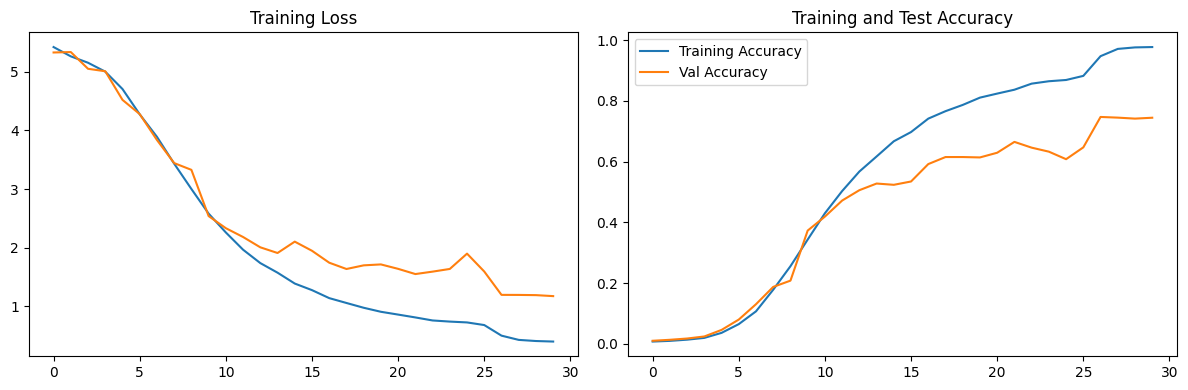

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(history["losses"], label="Training Losses")
axs[0].plot(history["test_losses"], label="Val Losses")
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(history["accuracies"], label="Training Accuracy")
axs[1].plot(history["test_accuracies"], label="Val Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

### Analyse de l'Évolution du Taux d'Apprentissage

Plongeons dans l'évolution du taux d'apprentissage de notre modèle au fil des époques. Ce graphique fournit des informations cruciales sur la manière dont le taux d'apprentissage change pendant l'entraînement, ce qui peut avoir un impact sur la convergence et les performances du modèle.

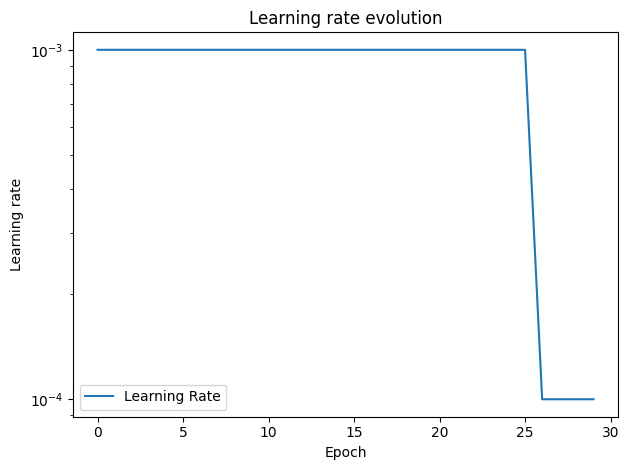

In [29]:
plt.plot(history['lr'])
plt.title("Learning rate evolution")
plt.legend(["Learning Rate"])

plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.yscale('log')
plt.tight_layout()
plt.show()

## Évaluation des Performances du Modèle sur l'Ensemble de Données de Test

Il est temps de mettre notre modèle entraîné à l'épreuve et de voir à quel point il se comporte bien sur des données invisibles ! Voici ce que nous faisons :

1. **Évaluation** : Nous mettons notre modèle en mode d'évaluation et itérons sur l'ensemble de données de test pour faire des prédictions.

2. **Matrice de Confusion** : Nous calculons la matrice de confusion pour comprendre à quel point notre modèle classe bien différentes classes.

3. **Précision** : Nous calculons la précision finale obtenue sur l'ensemble de données de test et l'affichons pour l'analyse.

Plongeons dans le code et voyons comment notre modèle se comporte dans le monde réel !

In [30]:
import torch.nn.functional as F

# Set the model to evaluation mode
model.eval()

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probs = []

# Iterate over the test dataset to make predictions
for images, labels in test_loader:
    # Transfer to GPU
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    probs, predicted = torch.max(outputs, 1)
    
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
    predicted_probs.extend(probs.cpu().detach().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the accuracy
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)

print("Final accuracy on the test dataset")
print(correct_predictions / total_predictions)

Final accuracy on the test dataset
0.747171031361138


### Visualisation de la Matrice de Confusion

Visualisons la matrice de confusion pour comprendre à quel point notre modèle se comporte bien dans différentes classes. Voici ce que nous faisons :

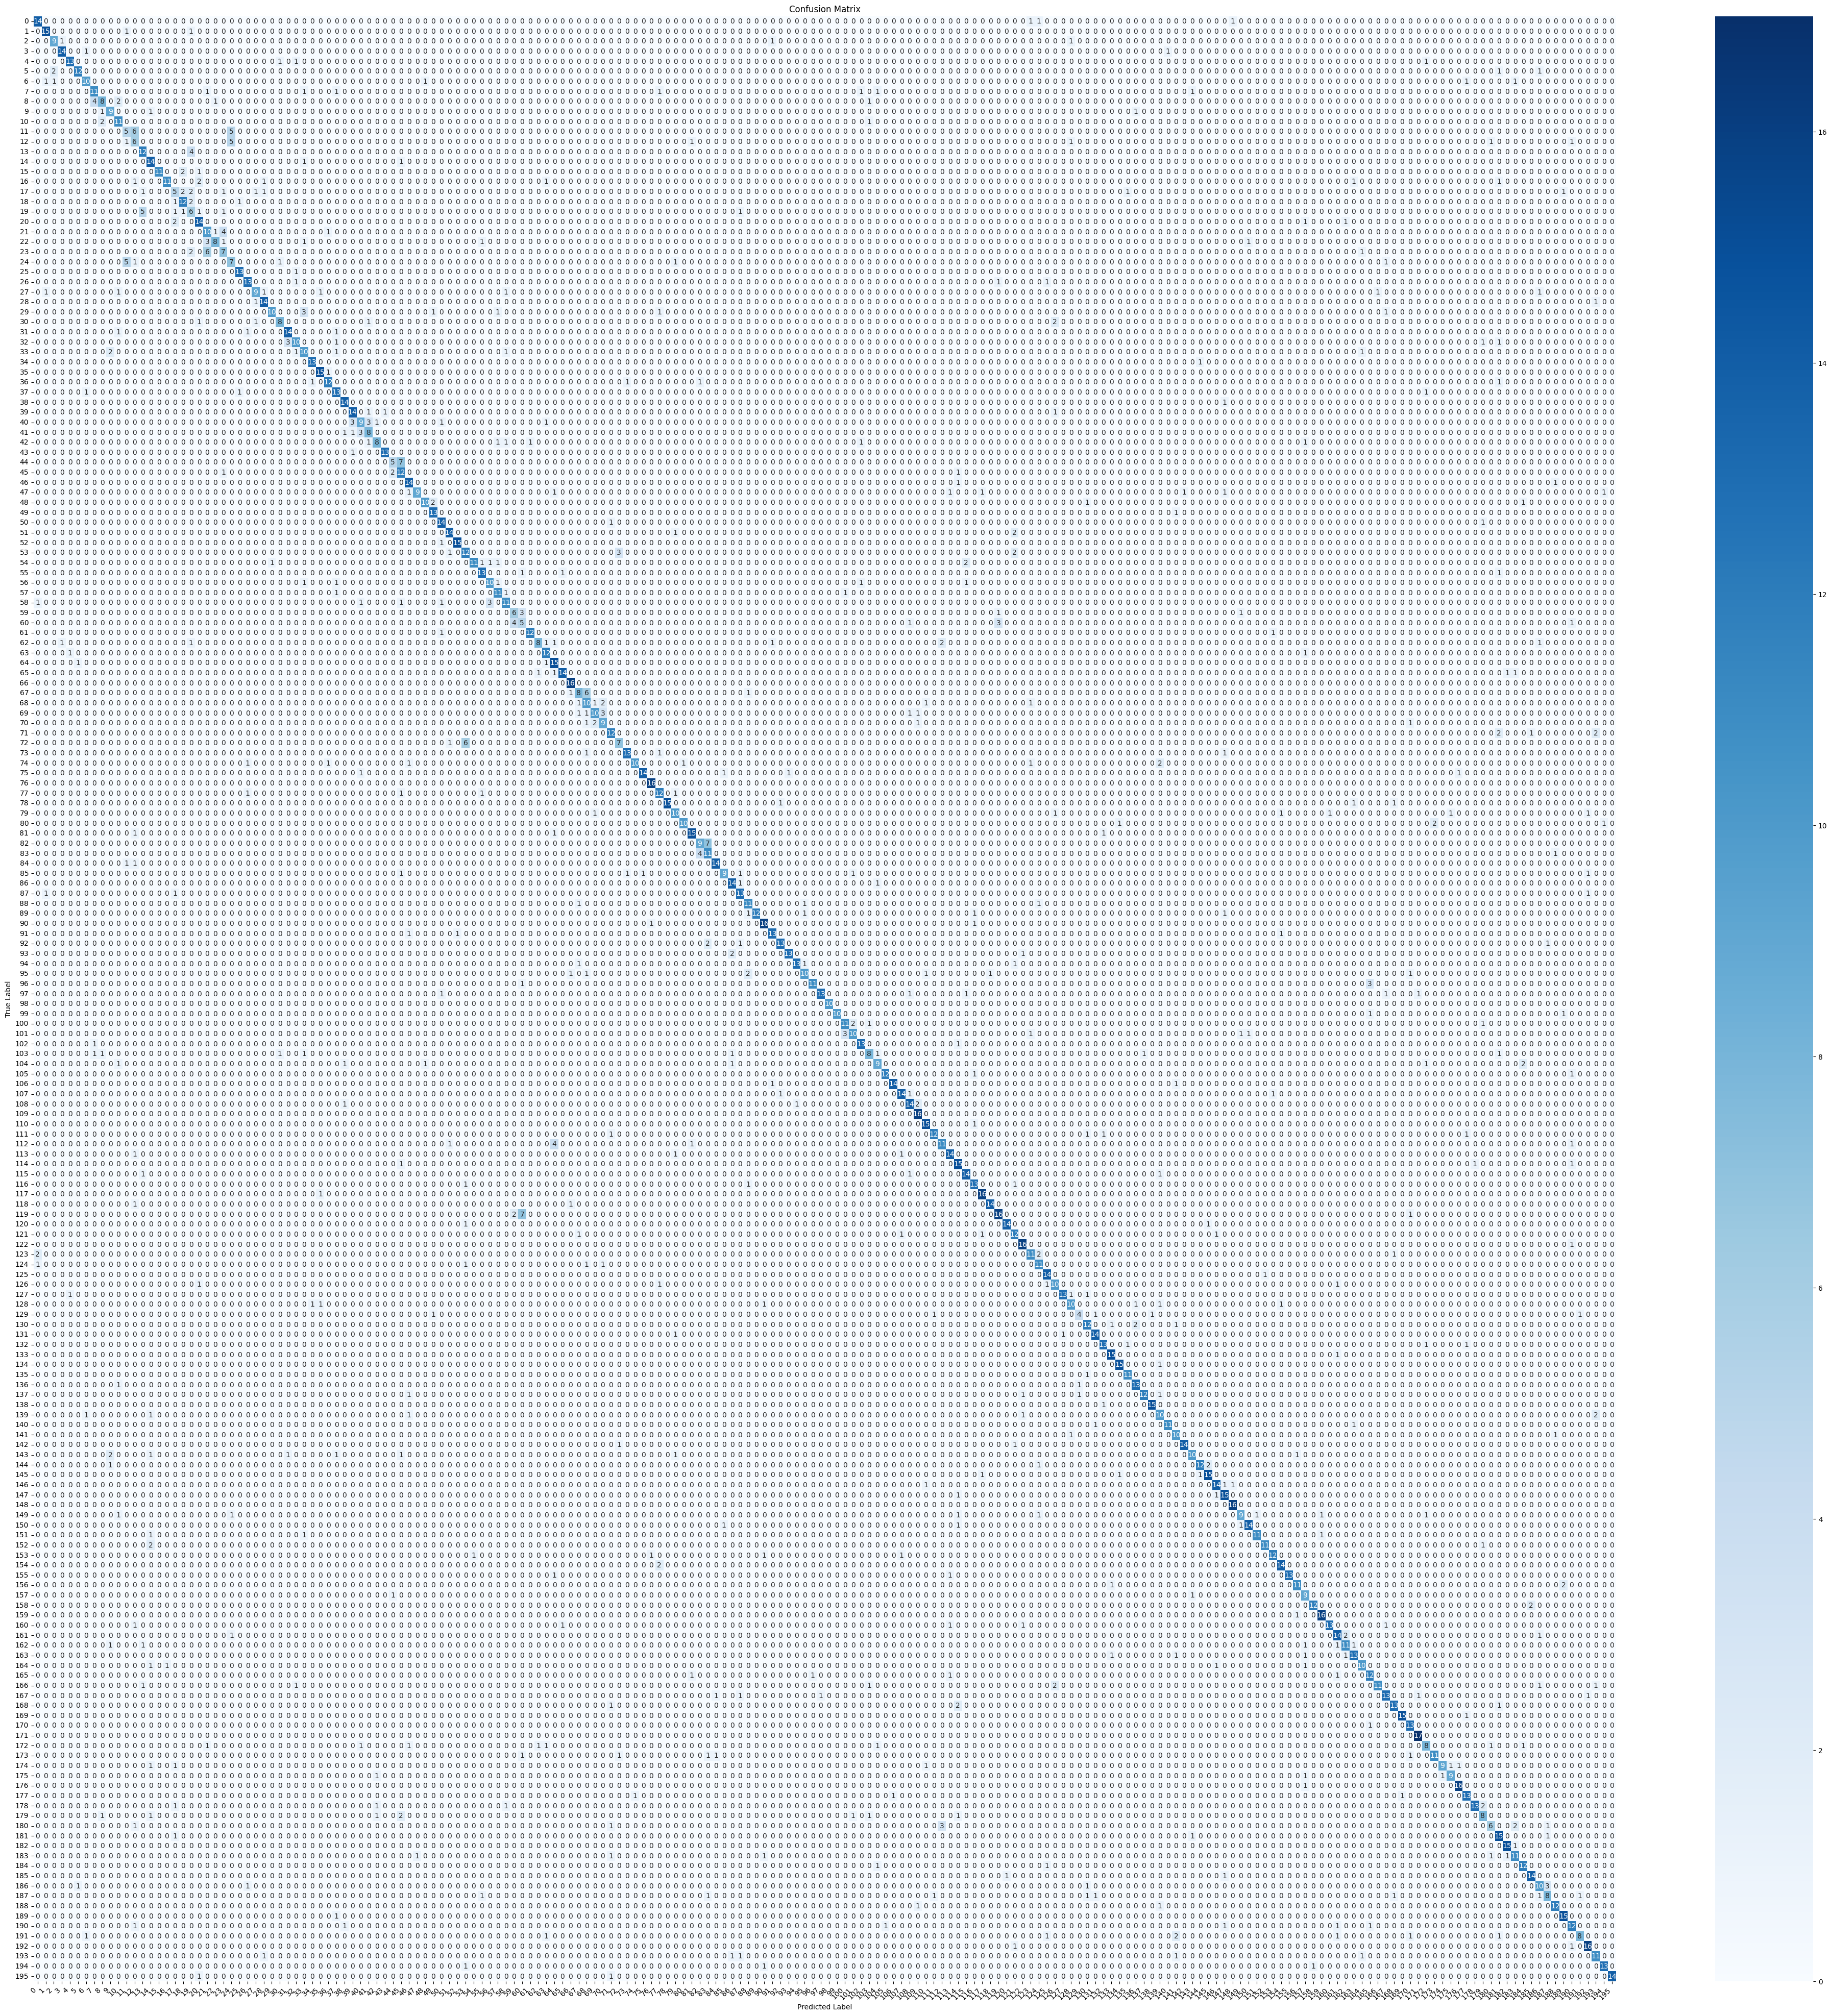

In [31]:
# Define the class labels
class_labels = [str(i) for i in range(len(conf_matrix))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

### Rapport de Classification

Générons et analysons le rapport de classification pour les prédictions de notre modèle sur l'ensemble de données de test. Voici ce que nous faisons :

In [32]:
# Compute the classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.83      0.88      0.86        17
           2       0.75      0.75      0.75        12
           3       0.88      0.88      0.88        16
           4       0.87      0.81      0.84        16
           5       0.86      0.75      0.80        16
           6       0.71      0.67      0.69        15
           7       0.65      0.61      0.63        18
           8       0.62      0.50      0.55        16
           9       0.60      0.75      0.67        12
          10       0.61      0.79      0.69        14
          11       0.38      0.31      0.34        16
          12       0.29      0.38      0.32        16
          13       0.57      0.75      0.65        16
          14       0.61      0.88      0.72        16
          15       1.00      0.79      0.88        14
          16       0.92      0.61      0.73        18
          17       0.38    

# Analyse des Prédictions Incorrectes

Penchons-nous de plus près sur les échantillons où notre modèle a fait des prédictions incorrectes. Voici ce que nous faisons :

1. **Identification** : Nous identifions les prédictions incorrectes et leurs probabilités correspondantes.

2. **Tri** : Les prédictions incorrectes sont triées en fonction de la confiance de la prédiction (probabilité), ce qui nous permet de nous concentrer sur les prédictions les plus incertaines.

3. **Affichage des Métriques des Échantillons** : Nous affichons les détails des 9 échantillons avec les pires prédictions, y compris leurs vraies étiquettes, étiquettes prédites et probabilités.

Plongeons dans le code et analysons ces exemples pour comprendre où notre modèle éprouve des difficultés et comment nous pouvons améliorer ses performances.

In [33]:
import numpy as np

# Find incorrect predictions and their corresponding probabilities
incorrect_predictions = []
for i, (true_label, predicted_label, prob) in enumerate(zip(true_labels, predicted_labels, predicted_probs)):
    if true_label != predicted_label:
        incorrect_predictions.append((i, true_label, predicted_label, prob))

# Sort the incorrect predictions based on prediction confidence (probability)
incorrect_predictions.sort(key=lambda x: x[3])

# Get the 9 samples with the worst loss predictions
print("Samples with the worst predictions:")
input_path = []

for i in range(9):
    index, true_label, predicted_label, prob = incorrect_predictions[i]
    input_path.append(image_index_to_path[index])
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {prob}")

Samples with the worst predictions:
True Label: 193, Predicted Label: 164, Probability: -3.069206476211548
True Label: 164, Predicted Label: 146, Probability: -2.2781972885131836
True Label: 95, Predicted Label: 170, Probability: -1.651811122894287
True Label: 57, Predicted Label: 37, Probability: -1.5630061626434326
True Label: 125, Predicted Label: 152, Probability: -1.4897397756576538
True Label: 32, Predicted Label: 179, Probability: -1.4784142971038818
True Label: 168, Predicted Label: 114, Probability: -1.47102952003479
True Label: 74, Predicted Label: 26, Probability: -1.4418537616729736
True Label: 26, Predicted Label: 119, Probability: -1.3430359363555908


### Visualisation des Cartes d'Activation pour les Prédictions Incorrectes

Visualisons les cartes d'activation pour les images où notre modèle a fait des prédictions incorrectes. Voici ce que nous faisons :

1. **Extraction des Cartes d'Activation** : Nous utilisons SmoothGradCAM++ pour extraire les cartes d'activation pour chaque image de notre liste de prédictions incorrectes.

2. **Superposition des Masques** : Nous visualisons ces cartes d'activation aux côtés des images correspondantes pour comprendre quelles régions des images influencent les décisions de notre modèle.

Plongeons dans le code et explorons ces cartes d'activation pour obtenir des informations sur le processus de prise de décision de notre modèle.

In [34]:
activation_map = []
images_map = []
with SmoothGradCAMpp(model) as cam_extractor:
    for error_path in input_path:
        img = read_image(error_path)
        input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        input_tensor = input_tensor.to(device)
        out = model(input_tensor.unsqueeze(0))
        
        # Retrieve the CAM by passing the class index and the model output
        images_map.append(img)
        activation_map.append(cam_extractor(out.squeeze(0).argmax().item(), out))

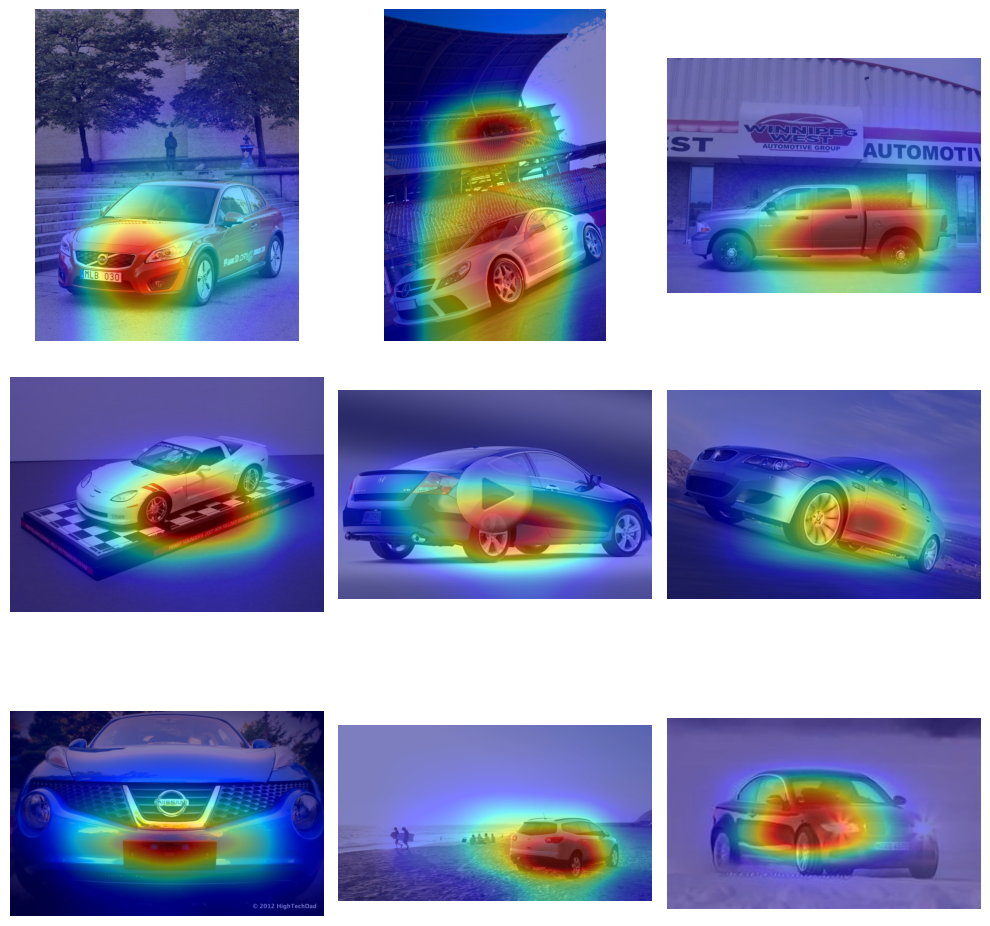

In [35]:
# Display each image on a subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, (img, act_map) in enumerate(zip(images_map, activation_map)):
    result = overlay_mask(to_pil_image(img), to_pil_image(act_map[0].squeeze(0), mode='F'), alpha=0.5)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(result)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Génération de données d'entraînement SmoothGradCAM++

**Fonction smooth_grad_training_data**
Cette fonction génère des données d'entraînement ainsi que des cartes d'activation SmoothGradCAM++. Elle prend en paramètre `class_name` indiquant la classe pour laquelle les données d'entraînement sont générées.
1. Elle itère sur les images dans le répertoire de classe spécifié.
2. Prétraite chaque image.
3. Passe chaque image prétraitée à travers un modèle.
4. Extrait la CAM (Carte d'Activation de Classe) en utilisant SmoothGradCAM++.
5. Ajoute le tenseur CAM à une liste.
6. Renvoie une liste d'images PIL (images originales) et une liste de cartes d'activation en tant que tenseurs.

**Fonction pil_to_tensor**
Convertit une image PIL en un tenseur PyTorch.

**Fonction get_mask_img**
Cette fonction génère des cartes de masque sur les images.
1. Elle appelle `smooth_grad_training_data` pour obtenir des cartes d'activation et des images originales.
2. Itère sur chaque paire d'image originale et de carte d'activation.
3. Convertit la carte d'activation en une image PIL.
4. La superpose sur l'image originale.
5. Convertit la superposition en un tenseur et l'ajoute à une liste.
6. Renvoie une liste d'images PIL (images originales) et une liste de cartes de masque en tant que tenseurs.

In [ ]:
from torchvision.transforms import functional as F

def smooth_grad_training_data(class_name: str) -> tuple:
    """
    Generates training data with SmoothGradCAM++ activation maps.

    Parameters:
    - class_name (str): The name of the class for which training data is generated.

    Returns:
    - List: A list containing activation maps as tensors.
    """
    activation_map_tensor = []
    images_map_pil = []

    with SmoothGradCAMpp(model) as cam_extractor:
        for sample_name in os.listdir(os.path.join(TRAIN_PATH, class_name)):
            sample_path = os.path.join(TRAIN_PATH, class_name, sample_name)
            img = read_image(sample_path)
            
            if img.size()[0] == 1:  # Single channel image
                print('Skipping Grayscale image ->', sample_path)
                continue
            input_tensor = normalize(
                resize(img, (224, 224)) / 255.,
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]
            )
            
            input_tensor = input_tensor.to(device)
            out = model(input_tensor.unsqueeze(0))

            # Retrieve the CAM 
            images_map_pil.append(img)
            cam = cam_extractor(out.squeeze(0).argmax().item(), out)

            # Append the mask to a list of masks        
            activation_map_tensor.append(cam)
    
    return images_map_pil, activation_map_tensor

def pil_to_tensor(image_pil):
    """Convert PIL Image to a PyTorch tensor."""
    transform = transforms.ToTensor()
    return transform(image_pil)

def get_mask_img(class_name: str) -> tuple:
    """
    Generates mask maps over images.

    Parameters:
    - class_name (str): The name of the class for which training data is generated.

    Returns:
    - List: A list containing mask maps as tensors.
    """
    mask_tensor = []
    images_map_pil, activation_map_tensor = smooth_grad_training_data(class_name)
    for i, (img, act_map) in enumerate(zip(images_map_pil, activation_map_tensor)):
        mask = to_pil_image(act_map[0].squeeze(0), mode='F')

        # Append the mask to the list of masks
        mask_tensor.append(pil_to_tensor(overlay_mask(to_pil_image(img), mask, alpha=0.01)))
    
    return images_map_pil, mask_tensor

### Application de flou variable sur l'application de masque

Ce code définit une fonction pour appliquer un flou variable sur une image en fonction d'un masque.

**Fonction `apply_variable_blur_on_mask`**
Cette fonction prend en entrée un tenseur d'image et un tenseur de masque et applique un flou variable à l'image en fonction du masque.
1. Convertit les tenseurs d'image et de masque en images PIL.
2. Divise le masque en canaux séparés (R, V, B).
3. Détermine le masque alpha en comparant le canal rouge aux canaux vert et bleu.
4. Applique un flou gaussien à l'image en utilisant le rayon de flou maximum spécifié.
5. Combine l'image floue avec l'image originale en fonction du masque alpha pour créer l'image finale.
6. Convertit l'image finale en un tenseur et la retourne.

Le flou variable est appliqué sélectivement aux pixels de l'image en fonction des conditions spécifiées dans le masque alpha, ce qui permet d'obtenir des effets de flou personnalisables.

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision.transforms import ToPILImage, ToTensor

def apply_variable_blur_on_mask(image_tensor, mask_tensor, max_blur_radius=5):
    # Convert tensors to PIL Images
    to_pil = ToPILImage()
    image_pil = to_pil(image_tensor)
    mask_pil = to_pil(mask_tensor)

    # Split mask into separate channels
    r, g, b = mask_pil.split()
    r_tensor = ToTensor()(r)
    g_tensor = ToTensor()(g)
    b_tensor = ToTensor()(b)

    # Only blur pixels respecting the following condition
    alpha_tensor = (r_tensor >= 2 * g_tensor) & (r_tensor >= 2 * b_tensor)

    alpha = ToPILImage(mode='L')(alpha_tensor.float())

    # apply gaussian blur to the image
    blurred_image = image_pil.filter(ImageFilter.GaussianBlur(max_blur_radius))

    # Create a new image with the blur
    final_image = Image.new("RGB", image_pil.size)
    final_image.paste(blurred_image, (0, 0), alpha)
    final_image.paste(image_pil, (0, 0), ImageChops.invert(alpha))

    # Convert back to tensor
    to_tensor = ToTensor()
    result_tensor = to_tensor(final_image)

    return result_tensor

## Floutage d'images et sauvegarde

Ce segment de code crée des images floutées basées sur des cartes d'activation et les sauvegarde dans un répertoire.

### Variables
- `FOLDER_NAME`: Le nom du répertoire où les images floutées seront sauvegardées.
- `anciennes_images_d_entrainement`: Liste des classes provenant du répertoire d'images d'entraînement d'origine.

In [ ]:
# Create a directory to save the blurred images
FOLDER_NAME = "blur_train"
create_dir(FOLDER_NAME)
old_training_images = os.listdir(TRAIN_PATH)
print(f"number of classes: {len(old_training_images)}")


for class_name in tqdm(old_training_images):
    create_dir(os.path.join(FOLDER_NAME, class_name))
    images_map_pil, mask_tensor = get_mask_img(class_name)
    
    # Apply blur to the images based on activation map and save them
    for i, (original_image_tensor, activation) in enumerate(zip(images_map_pil, mask_tensor)):

        #function applying blur to the original image
        blurred_image_tensor = apply_variable_blur_on_mask(original_image_tensor, activation, 5)
        blurred_image_pil = transforms.ToPILImage()(blurred_image_tensor)

        # Display or save the result
        # blurred_image_pil.show()
        
        blurred_image_pil.save(os.path.join(DATA_PATH, FOLDER_NAME, class_name, f"blurred_{i}.jpg"))

### Display random Images in the BLUR Dataset

In [ ]:
# Visualizing Random Samples from Training Data
plt.figure(figsize=(10, 10))
NEW_TRAIN_DATA = os.path.join(DATA_PATH, FOLDER_NAME)
classes_directory = random.choices(os.listdir(NEW_TRAIN_DATA), k=9)
print(classes_directory)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(NEW_TRAIN_DATA, class_name)))
    image_path = os.path.join(NEW_TRAIN_DATA, class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

## Create and Train another model on the BLUR Dataset

In [ ]:
new_train_dataset = torchvision.datasets.ImageFolder(root=NEW_TRAIN_DATA, transform = train_augmentation)
new_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = num_cores)

In [ ]:
new_model = torchvision.models.resnet18(progress=True, pretrained=True)

num_ftrs = new_model.fc.in_features
no_classes = len(train_dataset.classes)
new_model.fc = nn.Linear(num_ftrs, no_classes)
new_model = new_model.to(device)

# Defining the loss function and the optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
optimizer = optim.Adam(new_model.parameters(), weight_decay=5e-5)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=3, min_lr=0.00001, verbose=True)

NEPOCHS = 30

# Train the model
history = train_model(
    new_model,
    new_train_loader, 
    val_loader,
    criterion,
    optimizer,
    lrscheduler,
    device,
    n_epochs=NEPOCHS
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(history["losses"], label="Training Losses")
axs[0].plot(history["test_losses"], label="Val Losses")
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(history["accuracies"], label="Training Accuracy")
axs[1].plot(history["test_accuracies"], label="Val Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(history['lr'])
plt.title("Learning rate evolution")
plt.legend(["Learning Rate"])

plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

# Set the model to evaluation mode
new_model.eval()

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probs = []

# Iterate over the test dataset to make predictions
for images, labels in test_loader:
    # Transfer to GPU
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = new_model(images)
    probs, predicted = torch.max(outputs, 1)
    
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
    predicted_probs.extend(probs.cpu().detach().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the accuracy
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)

print("Final accuracy on the test dataset")
print(correct_predictions / total_predictions)

In [ ]:
# Define the class labels
class_labels = [str(i) for i in range(len(conf_matrix))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

In [ ]:
# Compute the classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)